In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
#from sklearn.multioutput import MultiOutputClassifi

## Part 1

In [378]:
class Markov_model:
    def __init__(self, T = 10, n = 2, alpha = 0.9, beta = 0.2, gamma = 0.1, lamb0 = 1, lamb1  = 5) -> None:
        #Customizable values
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.lamb0 = lamb0
        self.lamb1 = lamb1
        self.T = T
        self.n = n


        #--- Given probabilities---
        self.prob_C1 = np.array([0,0,1])
        self.Z_given_C = np.array([[self.alpha, 1-self.alpha],[1-self.alpha, self.alpha], [0.5, 0.5]])  #(C, Z)
        #self.alpha_C = np.array([1-self.alpha, self.alpha, 0.5])

        self.rates = [self.lamb0, self.lamb1]
        self.Gamma = np.array([[1-self.gamma, 0, self.gamma], #(Ci, Ci_plus1)
                          [0, 1-self.gamma, self.gamma], 
                          [self.beta/2, self.beta/2, 1-self.beta]])
        self.model_values = [self.lamb0, self.lamb1, self.alpha, self.beta, self.gamma] 
        
    def update_values(self):
        self.Z_given_C = np.array([[self.alpha, 1-self.alpha],[1-self.alpha, self.alpha], [0.5, 0.5]])  #(C, Z)
        self.rates = [self.lamb0, self.lamb1]
        self.Gamma = np.array([[1-self.gamma, 0, self.gamma], #(Ci, Ci_plus1)
                          [0, 1-self.gamma, self.gamma], 
                          [self.beta/2, self.beta/2, 1-self.beta]])
        #self.alpha_C = np.array([1-self.alpha, self.alpha, 0.5])
        self.model_values = [self.lamb0, self.lamb1, self.alpha, self.beta, self.gamma]
    
    
    def sim_data(self, n = 0 , T = 0, return_output = True):
        if n == 0:
            n = self.n
        else:
            self.n = n

        if T == 0:
            T = self.T
        else:
            self.T = T
            
        #Defining the three possible values of C
        ck = np.arange(3)   

        #Creating   random variables with probabilities based of the gamma matrix
        C_transition = [
            stats.rv_discrete(values=(ck,self.Gamma[0,])),#P(C_t |C_{t-1} = 0)
            stats.rv_discrete(values=(ck,self.Gamma[1,])),#P(C_t |C_{t-1} = 1)
            stats.rv_discrete(values=(ck,self.Gamma[2,])),#P(C_t |C_{t-1} = 2)
        ]
        
        #Creating output vector of C's
        C = np.zeros(self.T, np.int64)
        
        #Initializing the C vector
        C[0] = 2

        #Filling up the C-vector with values
        for i in range(self.T-1):
            C[i+1] = C_transition[C[i]].rvs()
        self.C = C
        
        #Initializing Z. size=[n,T] specifies we need to create n copies of a series of T simulations
        self.Z = stats.bernoulli([self.Z_given_C[c,1] for c in C]).rvs(size=[self.n,self.T])
        #input:
        '''
        [C_1, C_2, ... C_T]
        '''
        #output: 
        '''[   
            [Z_11, Z_21, Z_31, ... , Z_T1]
            [Z_12, Z_22, Z_32, ... , Z_T2]
            ...
            [Z_1n, Z_2n, Z_3n, ... , Z_Tn]
        ]'''

        #Initialize X   
        self.X = stats.poisson(np.where(self.Z, self.lamb1, self.lamb0)).rvs() #(n, T)
        #input
        '''[   
            [f(Z_11), f(Z_21), f(Z_31), ... , f(Z_T1)]
            [f(Z_12), f(Z_22), f(Z_32), ... , f(Z_T2)]
            ...
            [f(Z_1n), f(Z_2n), f(Z_3n), ... , f(Z_Tn)]
            ]    
            where
            f(z) = lamb0+(lamb1-lamb0)*z
        '''

        #output
        '''[   
            [X_11, X_21, X_31, ... , X_T1]
            [X_12, X_22, X_32, ... , X_T2]
            ...
            [X_1n, X_2n, X_3n, ... , X_Tn]
        ]'''
        if return_output:
            return self.C, self.Z, self.X
        else:
            return
    
    def find_P_X_given_C(self):
        self.P_X_given_Z = np.array([stats.poisson.pmf(k = self.X, mu = self.lamb0), #All of the potentials
                            stats.poisson.pmf(k = self.X, mu = self.lamb1)]) #(Z, n, T)
        
        self.P_X_given_C = np.einsum("ZnT, CZ -> TnC",self.P_X_given_Z, self.Z_given_C) #(Time, n, C)

    def upwards_passing(self):
        #Defining properties
        delta_Mi_to_Li = np.empty(shape = (self.T-1, 3)) #(Time, Ci)
        delta_Li_to_Mi_plus = np.empty(shape = (self.T-1, 3)) #(C_{i+1})
        belief_Li = np.empty(shape = (self.T, 3, 3)) #(T, C_i, C_{i+1})
    
        for i in range(self.T-1):
            #----------------Sending messages-------------
            #finding message Ci, Zi -> Ci+, Ci+
            if i == 0:
                delta_Mi_to_Li[i] = np.prod(self.P_X_given_C[i,:,:], axis = 0)*self.prob_C1 #C1
                #delta_Mi_to_Li[i] = np.exp(np.sum(np.log(self.P_X_given_C[i,:,:]), axis = 0)) * self.prob_C1 #C1
            else:
                #delta_Mi_to_Li[i] = np.exp(np.sum(np.log(self.P_X_given_C[i,:,:]), axis = 0)+np.log(delta_Li_to_Mi_plus[i-1])) #Ci
                delta_Mi_to_Li[i] = np.prod(self.P_X_given_C[i,:,:], axis = 0)*delta_Li_to_Mi_plus[i-1] #Ci

            #normalizing
            delta_Mi_to_Li[i] /= np.sum(delta_Mi_to_Li[i])

            #Finding belief Li
            belief_Li[i] = np.einsum("cC,c -> cC", self.Gamma, delta_Mi_to_Li[i]) #c old (C_{i}), C new (C_{i+1})
            #normalizing
            belief_Li[i] /= np.sum(belief_Li[i])
            
            #finding message Ci Ci+ -> Ci+, Zi+
            delta_Li_to_Mi_plus[i] = np.sum(belief_Li[i], axis=0) #Summing out c old
            
            #normalizing
            delta_Li_to_Mi_plus[i] /= np.sum(delta_Li_to_Mi_plus[i])

        self.delta_Mi_to_Li = delta_Mi_to_Li
        self.delta_Li_to_Mi_plus = delta_Li_to_Mi_plus
        self.belief_Li = belief_Li
        return 
    
    def backwards_passing(self):
        delta_Mi_plus_to_Li = np.empty(shape= (self.T-1, 3)) #T, C
        delta_Li_to_Mi = np.empty(shape= (self.T -1, 3)) #T, C
        updated_belief_Li = np.empty(shape = (self.T-1, 3, 3)) #T, c old (C_{i}), C new (C_{i+1})       

        for i in range(self.T-1):
            #---- SENDING MESSAGES ----- #
            #find downwards message Mi+ -> Li
            j = self.T -1 - i -1 #finding opposite direvtion
            if i == 0: #then j = T-2, aka the last entry index in messages
                delta_Mi_plus_to_Li[j] = np.prod(self.P_X_given_C[j+1,:,:], axis = 0) #(C)
            else:
                delta_Mi_plus_to_Li[j] = np.prod(self.P_X_given_C[j+1,:,:], axis = 0)*delta_Li_to_Mi[j+1] #(C)
            #normalize
            delta_Mi_plus_to_Li[j] /= np.max(delta_Mi_plus_to_Li[j])

            # find message Li -> Mi
            delta_Li_to_Mi[j] = np.einsum("cC,C -> c", self.Gamma, delta_Mi_plus_to_Li[j]) #Summing out Ci+

            #normalize
            delta_Li_to_Mi[j] /= np.sum(delta_Li_to_Mi[j])

            #----Update clique belief of Li

            #find belief
            updated_belief_Li[j] = np.einsum("cC, C -> cC", 
                                             np.einsum("cC, c -> cC", self.Gamma, self.delta_Mi_to_Li[j]), 
                                             delta_Mi_plus_to_Li[j]) #old c (ci), new C (C_{i+1})
            #normalize
            updated_belief_Li[j] /= np.sum(updated_belief_Li[j])
            


        self.updated_belief_Li = updated_belief_Li
        self.delta_Li_to_Mi = delta_Li_to_Mi
        self.delta_Mi_plus_to_Li = delta_Mi_plus_to_Li
        
    def find_C_probabilites(self):
        #Define structures
        C_prob = np.empty(shape = (self.T, 3, 2)) #Time, C, the two methods

        for i in range(self.T-1):
            #
            guess_0 = np.sum(self.updated_belief_Li[i], axis=1) #summing out C_{i+1}
            guess_1 = np.sum(self.updated_belief_Li[i], axis= 0) #summing out C_i
            C_prob[i,:,0] = guess_0     #Time, C_val, left_cliques
            C_prob[i+1,:,1] = guess_1   #Time, C_val, right_cliques
        
        #Filling in gaps
        C_prob[0,:,1] = C_prob[0,:,0]   #First probability
        C_prob[-1,:,0] = C_prob[-1,:,1] #last probability


        self.C_probs = C_prob
        self.C_prob = C_prob[:,:,0]
        return 

    def find_Z_probabilities(self):
        delta_Mi_to_Nij = np.empty(shape = (self.T, 2)) #Time, Z_val: This message is the same accross neurons, it is only time dependent

        #Finding first T-1 messages
        for i in range(self.T-1):
            delta_Mi_to_Nij[i] = np.einsum("c, cZ -> Z", self.delta_Li_to_Mi[i], self.Z_given_C)

        #Finding last message
        delta_Mi_to_Nij[-1] = np.einsum("C, CZ -> Z", self.delta_Li_to_Mi_plus[-1], self.Z_given_C)      
        
        belief_Zij = np.einsum("TZ, ZnT -> nTZ", delta_Mi_to_Nij, self.P_X_given_Z) #(T,Z) x (Z, n, T) -> (n, T,Z)
        
        row_sums = np.sum(belief_Zij, axis=-1)

        #normalize
        belief_Zij/= row_sums[..., np.newaxis]

        self.belief_Zij = belief_Zij #(n, T, Z)
        self.delta_MI_to_Nij = delta_Mi_to_Nij #(Time, Z)
        return 

    def message_pass(self):
        self.find_P_X_given_C() #time, C
        self.upwards_passing()
        self.backwards_passing()
        self.find_C_probabilites()
        self.find_Z_probabilities()
        return self.C_prob, self.belief_Zij

    def find_probabilities(self):
        self.sim_data()
        self.find_P_X_given_C() #time, C
        self.upwards_passing()
        self.backwards_passing()
        self.find_C_probabilites()
        self.find_Z_probabilities()
        

    def variable_prediction_precision(self):
        self.find_probabilities()

        self.accuracy_Z = [(self.Z == z) - self.belief_Zij[:,:,z] for z in range(2)] #Average distance from true value for Z
        self.accuracy_C = [(self.C == i) - self.C_prob[:,i] for i in range(3)] #Average distance from true value for C's
        return self.accuracy_C, self.accuracy_Z
    
    
        

def check_simulation(N, model):
    val_c = np.empty(shape = (N, 3, model.T)) #N, C, T
    val_Z = np.empty(shape = (N, 2, model.n, model.T)) #N, Z, n, T
    for i in range(N):
        sim_i = Markov_model(T = model.T, n = model.n)
        val_c[i], val_Z[i] = sim_i.variable_prediction_precision()

    print("Did N = ", N, " simulations with n = ", model.n, " and T = ", model.T)
    print("greatest error for C is:", np.around(np.max(np.abs(np.mean(val_c, axis = 0)))*100, decimals = 2), "%")
    print("greatest error for Z is:", np.around(np.max(np.abs(np.mean(val_Z, axis = 0)))*100, decimals = 2), "%")
    print("Accuracy for estimates of C: \n", np.around(np.mean(val_c, axis = 0), decimals= 2))
    print("Accuracy for estimates of Z: \n", np.around(np.mean(val_Z, axis = 0), decimals= 2))
    return 

model = Markov_model(T = 10, n = 100)

# Forward Simulation

In [3]:
C, Z, X = model.sim_data(n = 5, T = 2)

# Visualizing

# Logistic regression

Packages:

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

Simulate lots of data

In [5]:
N = 100

n2 = 10
T = 100

#Training set
np.random.seed(42)
C, Z, X = np.empty(shape=(N,T)), np.empty(shape=(N,n2,T)), np.empty(shape=(N, n2,T))
for i in range(N):
    C[i], Z[i], X[i] = model.sim_data(n = n2, T = T)

#Benchmark set
np.random.seed(80)
N_test = 100
C_test, Z_test, X_test = np.empty(shape=(N_test,T)), np.empty(shape=(N_test,n2,T)), np.empty(shape=(N_test, n2, T))
for i in range(N_test):
    C_test[i], Z_test[i], X_test[i] = model.sim_data(n = n2,T = T)

Logistic regression using all the X's to predict $C_{50}$

#### Model 1

In [6]:
#Defining regression models
lr_model1 = LogisticRegression(max_iter=10000)

#Model 1 - using all X's
X_model1 = X[:,:,:].reshape((N, 100*n2))
lr_model1.fit(X_model1, C[:,49])   # [49] is C_50 because of zero-indexing
X_model1_test = X_test[:,:,:].reshape((N_test, 100*n2))

In [7]:
#model1
np.mean(lr_model1.predict(X_model1_test) == C_test[:,49])

0.67

#### Model 2

In [8]:
lr_model2 = LogisticRegression(max_iter=10000)

#Model 2 - using only neighbouring X's
X_model2 = X[:,:,48:51].reshape((N, 3*n2))
lr_model2.fit(X_model2, C[:,49])
X_model2_test = X_test[:,:,48:51].reshape((N_test, 3*n2))


In [9]:
#model 2
np.mean(lr_model2.predict(X_model2_test) == C_test[:,49])

0.8

#### Model 3

In [10]:
lr_model3 = LogisticRegression(max_iter=10000)

#Model 3 - using only descendant X's
X_model3 = X[:,:,49].reshape((N, n2))
lr_model3.fit(X_model3, C[:,49])
X_model3_test = X_test[:,:,49].reshape((N_test, n2))


In [11]:
#model 3
np.mean(lr_model3.predict(X_model3_test) == C_test[:,49])


0.67

#### Model 4

In [12]:
lr_model4 = LogisticRegression(max_iter=5000)

#Model 4 - using only neighbouring X's
X_model4 = X[:,:,0:39].reshape((N, 39*n2))
lr_model4.fit(X_model4, C[:,49])
X_model4_test = X_test[:,:,0:39].reshape((N_test, 39*n2))


In [13]:
#model 4
np.mean(lr_model4.predict(X_model4_test) == C_test[:,49])

0.34

# Learning

In [55]:
model = Markov_model()
model.sim_data(T = 100, return_output=False)


Below is a function for computing parameter estimates

In [15]:
a = np.array([[1,1,0], [0,3,0]])
b = np.array([1,0,1])
np.einsum("nT, T -> ", a, b) 

1

In [304]:
def learn_par(model, Print = False):
    n = model.n
    T = model.T
    Z = model.Z #n, T
    C = model.C #T
    X = model.X #n, T
    
    # Estimating lambda's
    lambda0_hat = np.sum((1-Z) * X) / (np.sum(1-Z))
    lambda1_hat = np.sum(Z * X) / np.sum(Z)

    # # Estimating alpha_hat
    if(np.sum(C==2) == T):
        return print("WARNING: No C==1 nor C== 0 have been observed and learning cannot proceed")

    alpha_hat  =  np.sum(Z == C)  / (np.sum(C != 2)*n)
    beta_hat   =  np.mean((C[:-1] == 2) & (C[1:] != 2)) / np.mean(C[:-1] == 2)
    gamma_hat  =  np.mean((C[:-1] != 2) & (C[1:] == 2)) / np.mean(C[:-1] != 2)

    if (Print == True):
        print("lambda0_hat is: ", lambda0_hat, "\n lambda1_hat is: ", lambda1_hat, "\nalpha_hat is:", alpha_hat, "\nbeta_hat is: ", beta_hat, "\ngamme_hat is: ", gamma_hat)
    
    model.estimates = {
        "lamb0_hat": lambda0_hat,
        "lamb1_hat": lambda1_hat,
        "alpha_hat": alpha_hat,
        "beta_hat":  beta_hat,
        "gamma_hat": gamma_hat
    }
    return model.estimates

In [310]:
model.sim_data(T = 100)
print(learn_par(model))
print(model.model_values)

{'lamb0_hat': 0.9942678478374153, 'lamb1_hat': 5.024510959226962, 'alpha_hat': 0.8948979591836734, 'beta_hat': 0.19607843137254902, 'gamma_hat': 0.1875}
[1, 5, 0.9, 0.2, 0.1]


Test the implementation using simulated data

In [311]:
N_rep = 100

model = Markov_model(gamma = 0.4, T = 1000, n = 100)
par_estimates = np.empty(shape =(N_rep,5))
for i in range(N_rep):
    model.sim_data(return_output=False)
    estimate_i = learn_par(model)
    par_estimates[i, 0] = estimate_i["lamb0_hat"]
    par_estimates[i, 1] = estimate_i["lamb1_hat"]
    par_estimates[i, 2] = estimate_i["alpha_hat"]
    par_estimates[i, 3] = estimate_i["beta_hat"]
    par_estimates[i, 4] = estimate_i["gamma_hat"]   

names = ["lambda0", "lambda1", "alpha", "beta", "gamma"]
true_vals = [model.lamb0, model.lamb1, model.alpha, model.beta, model.gamma]

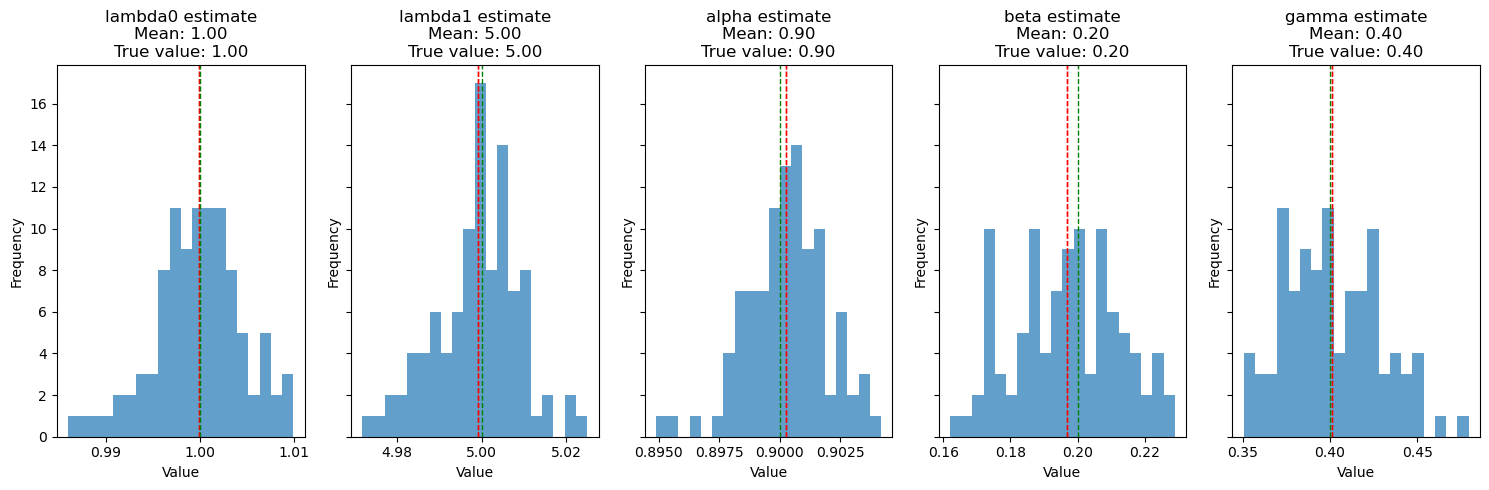

In [216]:
# Create subplots with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

# Iterate through each subplot
for i, ax in enumerate(axes):
    # Plot histogram
    ax.hist(par_estimates[:,i], bins=20, alpha=0.7)
    
    # Calculate mean
    mean_value = np.mean(par_estimates[:,i])
    
    # Add vertical line for the mean
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)

    # Add vertical line for true value
    ax.axvline(true_vals[i], color='green', linestyle='dashed', linewidth=1)
    
    # Set title
    ax.set_title(f'{names[i]} estimate\nMean: {mean_value:.2f}\nTrue value: {true_vals[i]:.2f}')
    
    # Set labels
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Save plot
plt.savefig('histograms_with_means.png')

# Show plot
plt.show()

In [255]:
model = Markov_model(T = 10, n = 100)
model.sim_data()

(array([2, 2, 1, 2, 2, 2, 2, 2, 2, 2]),
 array([[1, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 0, 1],
        [0, 0, 1, 0, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 0, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [0, 1, 1, 0, 1, 1, 1, 0, 1, 0],
        [1, 0, 1, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 1, 0, 1, 0],
        [0, 1, 1, 0, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 1, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 0, 1, 0, 1],
        [0, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 1, 1, 0, 0],


In [24]:
model.X.shape

(100, 10)

In [336]:
#---- EM ----
def hardEM(X, convergence_limit = 1e-5, limit = 100, initial_dic = {'lamb0_hat': 1, 'lamb1_hat': 10, 'alpha_hat': 0.9, 'beta_hat': 0.5, 'gamma_hat': 0.5}, verbose = 0):
    data_n = X.shape[0]
    data_T = X.shape[1]
    model = Markov_model(n = data_n, T = data_T)
    model.X = X
    
    #Updating working model
    distance = 100
    model.alpha = initial_dic["alpha_hat"]
    model.beta  = initial_dic["beta_hat"]
    model.gamma = initial_dic["gamma_hat"]
    model.lamb0 = initial_dic["lamb0_hat"]
    model.lamb1 = initial_dic["lamb1_hat"]
    if verbose > 0:
        print("initial_values are", model.model_values)
    model.update_values()
    current_est  = np.empty(shape = (limit+1,5 ))
    current_est[0] = list(initial_dic.values())
    #Resetting the timer
    N = 0
    distance = 10
    while (N<limit) & (distance > convergence_limit):
        N += 1
        
        model.message_pass()
        C_guess = np.argmax(model.C_prob, axis = 1) #(T)
        Z_guess = np.argmax(model.belief_Zij, axis = 2) #(n T Z)
        model.C = C_guess
        model.Z = Z_guess
        
        parameter_guess = learn_par(model)

        #Update model values
        model.alpha = parameter_guess["alpha_hat"]
        model.beta = parameter_guess["beta_hat"]
        model.gamma = parameter_guess["gamma_hat"]
        model.lamb0 = parameter_guess["lamb0_hat"]
        model.lamb1 = parameter_guess["lamb1_hat"]
        model.update_values()

        list_parameter_guess = list(parameter_guess.values())
        #Save current estimate
        current_est[N] = list_parameter_guess
        #calculate distance
        distance = np.max(current_est[N-1]-current_est[N])

    if verbose > 0:
        if(N < limit):
            print("Convergence acheived after N =  ", N, "steps")
            current_est = current_est[0:(N+1),:]
        else:
            print("No convergence after N = ", limit, "steps")
    
    model.estimates = parameter_guess

    return model.estimates, current_est


final, est_list = hardEM(test_X, limit = 50, initial_dic=initial_dic)
final, true_model.model_values

({'lamb0_hat': 0.9221748869076376,
  'lamb1_hat': 5.162700598582498,
  'alpha_hat': 0.8902840059790732,
  'beta_hat': 0.20606060606060608,
  'gamma_hat': 0.101644245142003},
 [1, 5, 0.9, 0.2, 0.1])

In [434]:

def learn_par_soft(model, Print = False):
    n = model.n
    T = model.T
    Z = model.belief_Zij #n, T, 2
    C = model.C_prob #T, 3
    X = model.X  #n, T
    
    # Estimating lambda's
    lambda0_hat = np.sum(Z[:,:,0] * X) / (np.sum(Z[:,:,0]))
    lambda1_hat = np.sum(Z[:,:,1] * X) / np.sum(Z[:,:,1])

    # # Estimating alpha_hat
    if(np.sum(C[:,2]) == T):
        return print("WARNING: No C==1 nor C== 0 have been observed and learning cannot proceed")

    alpha_hat =  np.mean(C[:,0] * Z[:,:,0] + C[:,1] * Z[:,:,1]) / (np.mean(C[:,0] + C[:,1]))
    beta_hat  =  np.mean(C[:-1,2] * (C[1:,0] + C[1:,1])) / np.mean(C[:-1,2])
    gamma_hat =  np.mean((C[:-1,0] + C[:-1,1]) * C[1:,2]) / np.mean(C[:-1,0] + C[:-1,1])

    if (Print == True):
        print("lambda0_hat is: ", lambda0_hat, "\n lambda1_hat is: ", lambda1_hat, "\nalpha_hat is:", alpha_hat, "\nbeta_hat is: ", beta_hat, "\ngamme_hat is: ", gamma_hat)
    
    print(np.mean(C[:,0] * Z[:,:,0]), np.mean(C[:,1] * Z[:,:,1]), np.mean(C[:,0] + C[:,1]))

    model.estimates = {
        "lamb0_hat": lambda0_hat,
        "lamb1_hat": lambda1_hat,
        "alpha_hat": alpha_hat,
        "beta_hat":  beta_hat,
        "gamma_hat": gamma_hat
    }
    return model.estimates

In [435]:
#---- soft EM ----
def softEM(X, convergence_limit = 1e-6, limit = 500, initial_dic = {'lamb0_hat': 1, 'lamb1_hat': 10, 'alpha_hat': 0.9, 'beta_hat': 0.5, 'gamma_hat': 0.5}, verbose=0):
    data_n = X.shape[0]
    data_T = X.shape[1]
    model = Markov_model(n = data_n, T = data_T)
    model.X = X
    
    #Updating working model
    distance = 100
    model.alpha = initial_dic["alpha_hat"]
    model.beta = initial_dic["beta_hat"]
    model.gamma = initial_dic["gamma_hat"]
    model.lamb0 = initial_dic["lamb0_hat"]
    model.lamb1 = initial_dic["lamb1_hat"]
    if verbose > 0:
        print("initial_values are", model.model_values)
    model.update_values()
    current_est  = np.empty(shape = (limit+1,5 ))
    current_est[0] = list(initial_dic.values())
    #Resetting the timer
    N = 0
    distance = 10
    while (N<limit) & (distance > convergence_limit):
        N += 1
        
        model.message_pass()
        parameter_guess = learn_par_soft(model)

        #Update model values
        model.alpha = parameter_guess["alpha_hat"]
        model.beta = parameter_guess["beta_hat"]
        model.gamma = parameter_guess["gamma_hat"]
        model.lamb0 = parameter_guess["lamb0_hat"]
        model.lamb1 = parameter_guess["lamb1_hat"]
        model.update_values()

        list_parameter_guess = list(parameter_guess.values())
        #Save current estimate
        current_est[N] = list_parameter_guess
        #calculate distance
        distance = np.max(current_est[N-1]-current_est[N])

    if verbose > 0:
        if(N < limit):
            print("Convergence achieved after N =  ", N, "steps")
            current_est = current_est[0:(N+1),:]
        else:
            print("No convergence after N = ", limit, "steps")
    
    model.estimates = parameter_guess

    #print(model.C_probs)
    return model.estimates, current_est

true_model = Markov_model(T = 1000, n = 10)
true_model.sim_data()
test_X = true_model.X
final, est_list = softEM(test_X, limit = 200, initial_dic=initial_dic)
final, true_model.model_values

0.4456855283971495 0.07355696958159097 0.6733384716392523
0.4238379685748709 0.18273142664601086 0.7718629619703913
0.3827175596296134 0.23438727773246054 0.7852985616539703
0.3560010874260557 0.25728269800720793 0.7787978736665313
0.3400239325482614 0.2676414647649224 0.7685784821015218
0.3304759134327633 0.2717984771952578 0.7581958195395941
0.32455466034204666 0.2728024080783183 0.7484212530590316
0.3206710502867145 0.27224187336733124 0.7394299577192346
0.31796535968148526 0.2709651543885649 0.7312797052996306
0.3159787188899096 0.26942732352550114 0.7240011244339841
0.31446381175362303 0.26787011369387775 0.7176050486782474
0.3132821619274825 0.2664171200800335 0.7120774526783065
0.31235046683483825 0.2651251650312161 0.7073778433288722
0.3116135914827908 0.264012929530765 0.7034429361158833
0.3110315032852118 0.2630776108432243 0.7001936709360308
0.310573150446363 0.26230498996108476 0.6975431313677304
0.3102135962944627 0.261675624120293 0.6954035894361009
0.309932577930708 0.26

({'lamb0_hat': 0.9785869012493225,
  'lamb1_hat': 4.937506717920524,
  'alpha_hat': 0.8265996520847713,
  'beta_hat': 0.30398553145884966,
  'gamma_hat': 0.1374435083163981},
 [1, 5, 0.9, 0.2, 0.1])

In [349]:
N_rep = 100

initial_dic = {'lamb0_hat': 1, 'lamb1_hat': 10, 'alpha_hat': 0.95, 'beta_hat': 0.5, 'gamma_hat': 0.5} 
model = Markov_model(gamma = 0.4, T = 1000, n = 100)
test_X = true_model.X
final, est_list = softEM(test_X, limit = 50, initial_dic=initial_dic)
final, true_model.model_values

par_estimates = np.empty(shape =(N_rep,5))
for i in range(N_rep):
    model.sim_data(return_output=False)
    estimate_i, _ = hardEM(model.X)
    par_estimates[i, 0] = estimate_i["lamb0_hat"]
    par_estimates[i, 1] = estimate_i["lamb1_hat"]
    par_estimates[i, 2] = estimate_i["alpha_hat"]
    par_estimates[i, 3] = estimate_i["beta_hat"]
    par_estimates[i, 4] = estimate_i["gamma_hat"]   

names = ["lambda0", "lambda1", "alpha", "beta", "gamma"]
true_vals = [model.lamb0, model.lamb1, model.alpha, model.beta, model.gamma]

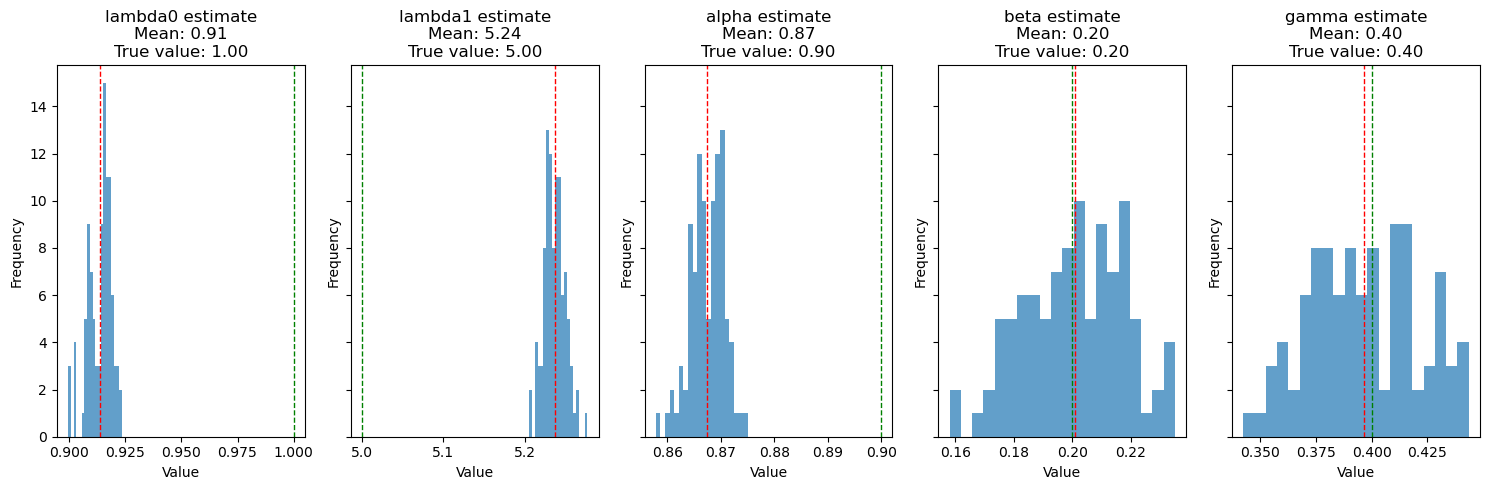

In [350]:
# Create subplots with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

# Iterate through each subplot
for i, ax in enumerate(axes):
    # Plot histogram
    ax.hist(par_estimates[:,i], bins=20, alpha=0.7)
        
    # Add vertical line for the mean and true values
    mean_value = np.mean(par_estimates[:,i])
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
    ax.axvline(true_vals[i], color='green', linestyle='dashed', linewidth=1)
    
    # Set title and labels
    ax.set_title(f'{names[i]} estimate\nMean: {mean_value:.2f}\nTrue value: {true_vals[i]:.2f}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('histograms_with_means.png')
plt.show()

In [412]:
N_rep = 100

initial_dic = {'lamb0_hat': 1, 'lamb1_hat': 10, 'alpha_hat': 0.6, 'beta_hat': 0.5, 'gamma_hat': 0.5} 
model = Markov_model(gamma = 0.4, T = 1000, n = 100)
test_X = true_model.X
final, est_list = softEM(test_X, limit = 50, initial_dic=initial_dic)
final, true_model.model_values

par_estimates_softEM = np.empty(shape =(N_rep,5))
for i in range(N_rep):
    model.sim_data(return_output=False)
    estimate_i, _ = softEM(model.X)
    par_estimates_softEM[i, 0] = estimate_i["lamb0_hat"]
    par_estimates_softEM[i, 1] = estimate_i["lamb1_hat"]
    par_estimates_softEM[i, 2] = estimate_i["alpha_hat"]
    par_estimates_softEM[i, 3] = estimate_i["beta_hat"]
    par_estimates_softEM[i, 4] = estimate_i["gamma_hat"]   

names = ["lambda0", "lambda1", "alpha", "beta", "gamma"]
true_vals = [model.lamb0, model.lamb1, model.alpha, model.beta, model.gamma]

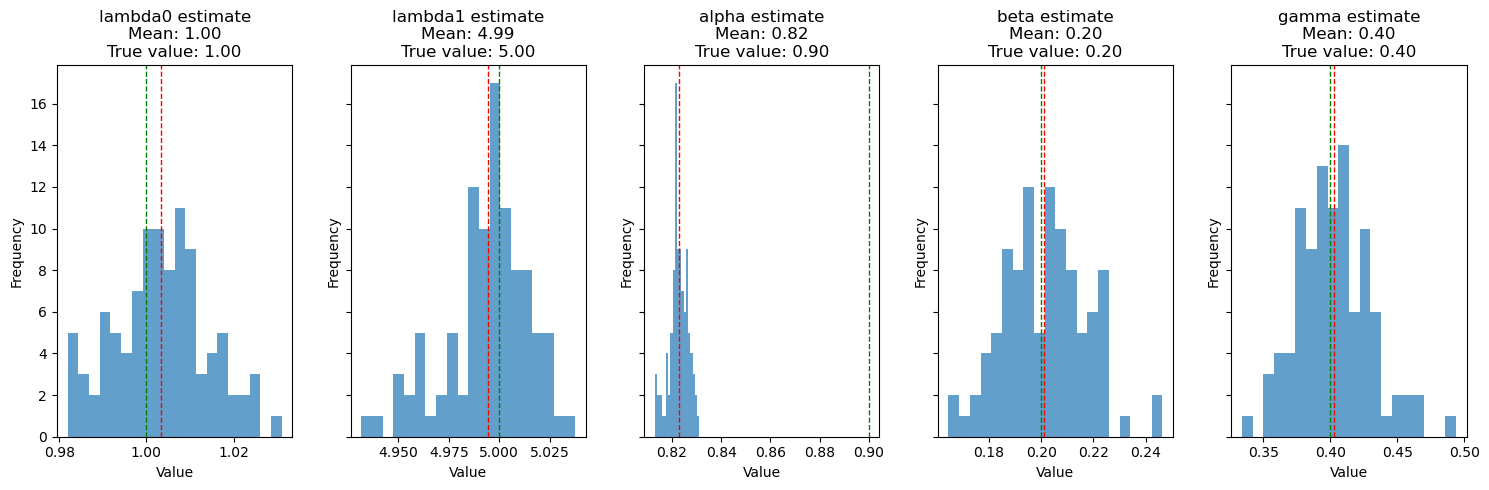

In [414]:
# Create subplots with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

# Iterate through each subplot
for i, ax in enumerate(axes):
    # Plot histogram
    ax.hist(par_estimates_softEM[:,i], bins=20, alpha=0.7)
        
    # Add vertical line for the mean and true values
    mean_value = np.mean(par_estimates_softEM[:,i])
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
    ax.axvline(true_vals[i], color='green', linestyle='dashed', linewidth=1)
    
    # Set title and labels
    ax.set_title(f'{names[i]} estimate\nMean: {mean_value:.2f}\nTrue value: {true_vals[i]:.2f}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('histograms_with_means.png')
plt.show()

array([0., 0., 1.])